# N.E.R

Named Entity Recognition (NER) is a subtask of information extraction in natural language processing (NLP). The goal of NER is to identify and classify named entities in text, such as people, organizations, locations, and other types of named entities. NER is a critical component in many NLP applications, such as text classification, sentiment analysis, and machine translation, as it allows for the extraction of structured information from unstructured text data. NER models typically use machine learning algorithms, such as rule-based models, statistical models, or deep learning models, to automatically identify and extract named entities from text. In recent years, deep learning approaches have shown promising results in NER, particularly with the use of neural network architectures such as Transformers

Here are some details about the entities of a NER:

**Person**: A named entity that refers to a human being, such as a person's name or a personal pronoun.

**Organization**: A named entity that refers to a group of people or entities that are organized for a specific purpose, such as a company, institution, or government agency.

**Location**: A named entity that refers to a specific place or geographical location, such as a city, state, country, or geographic feature.

**Date/Time**: A named entity that refers to a specific point in time or a duration of time, such as a date, time, or time interval.

**Product**: A named entity that refers to a specific product or brand, such as a product name, model number, or trademark.

**Event**: A named entity that refers to a specific event or occurrence, such as a conference, concert, or sports game.

**Money**: A named entity that refers to a specific amount of money, such as a currency symbol or monetary value.

**Percentage**: A named entity that refers to a specific percentage, such as a percentage symbol or numerical value.

**Miscellaneous**: A named entity that does not fit into any of the above categories, such as an acronym, abbreviation, or product category.

In [1]:
%%capture
!pip install transformers[sentencepiece] datasets sacremoses evaluate

In [2]:
import os
import json
import string
from pathlib import Path
from typing import Union
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import notebook
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from tqdm import notebook

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Data

In [3]:
#Connection with my drive folder
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
directory = 'drive/MyDrive/Colab_Notebooks/fulltext'

data = dict()

file_list = os.listdir(directory)

for filename in notebook.tqdm(file_list):
    with open(directory + "/" + filename, 'r') as f:
        raw_data = f.read()
    
    bs_data = BeautifulSoup(raw_data,'xml')
    
    texts = list()
    
    if bs_data.findChild('sentences') == None:
        # If there are no sentences, extract the text from each <text> tag
        for tag in bs_data.find_all('text'):
            texts.append(tag)
    else:
        # If there are sentences, extract the text from each <sentences> tag
        for tag in bs_data.find_all('sentences'):
            texts.append(tag)
    
    data[filename] = texts

  0%|          | 0/3890 [00:00<?, ?it/s]

In [5]:
def clean_data(doc:str) -> str:
    x = re.sub(r'\n', '', doc) #we remove \n
    x = re.sub(r"\'", '', x)
    return x

In [6]:
documents = [clean_data(data[key][0].text) for key in data.keys()]

In [7]:
#@title NER!
from transformers import pipeline

transformer = pipeline("ner", aggregation_strategy="simple", model="dbmdz/bert-large-cased-finetuned-conll03-english", device = 0)

The model "dbmdz/bert-large-cased-finetuned-conll03-english" is a pre-trained language model based on BERT (Bidirectional Encoder Representations from Transformers), which is a powerful deep learning model that has achieved state-of-the-art results in many natural language processing tasks, including named entity recognition (NER).

The model has been fine-tuned on the CoNLL 2003 NER dataset, which is a commonly used benchmark dataset for NER. This dataset consists of news articles from the Reuters Corpus that have been annotated with named entities in four categories: persons, organizations, locations, and miscellaneous entities. By fine-tuning the BERT model on this dataset, the model has learned to recognize and extract named entities from text with high accuracy.

One of the key strengths of BERT-based models is their ability to capture context and meaning from the surrounding words in a sentence, which is important for accurate NER. The model also uses a multi-layer neural network architecture that allows it to learn complex patterns and relationships between words in the text. Additionally, the model has been trained on a large corpus of text data, which has helped it to develop a strong understanding of the English language.

Overall, the "dbmdz/bert-large-cased-finetuned-conll03-english" model is a highly effective and accurate model for NER tasks in English language text data.

In [16]:
res = list()
dict_ner = dict()
for i, doc in notebook.tqdm(enumerate(documents)):
  doc_entities = list()
  for entity in transformer(doc):
    doc_entities.append(entity)
    res.append(entity)
  dict_ner[i] = str(doc_entities)

0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1045: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [17]:
res[0]

{'entity_group': 'ORG',
 'score': 0.99769664,
 'word': 'Refugee Review Tribunal',
 'start': 150,
 'end': 173}

In [20]:
list_words_ner = list()
for r in res:
  list_words_ner.append(r['word'])

In [21]:
# Count the occurrence of each word
word_counts = Counter(list_words_ner)

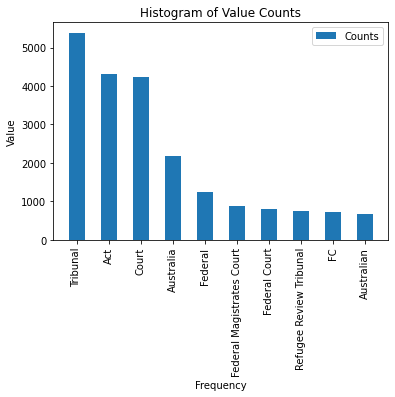

In [22]:
results = word_counts.most_common(10)

x = [str(val) for val, count in results]
y = [count for val, count in results]

fig, ax = plt.subplots()
ax.bar(x, y, width=0.5)
ax.tick_params(axis='x', rotation=90)

plt.xlabel("Frequency")
plt.ylabel("Value")

plt.title("Histogram of Value Counts")

plt.legend(["Counts"])

plt.show()

Our analysis has revealed that the entities "Tribunal," "Act," and "Court" are the most frequently occurring entities in the corpus. This finding is consistent with expectations, given the legal domain of the text data

### Entity Group

In [13]:
list_group_ner = list()
for r in res:
  list_group_ner.append(r['entity_group'])

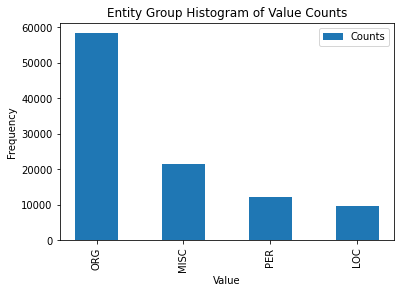

In [23]:
word_counts = Counter(list_group_ner)

results_ = word_counts.most_common(10)

x = [str(val) for val, count in results_]
y = [count for val, count in results_]

fig, ax = plt.subplots()
ax.bar(x, y, width=0.5)
ax.tick_params(axis='x', rotation=90)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Entity Group Histogram of Value Counts")
plt.legend(["Counts"])
plt.show()

The NER uses a "dbmdz/bert-large-cased-finetuned-conll03-english" model, we have 57% of entities of type ORG, 21% of entities of type MISC, 12% of entities of type PER and 10% of type LOC

Our analysis has revealed that a significant proportion of the entities in the corpus are organizational (ORG) in nature. However, there exists a sizeable number of Miscellaneous (MISC) entities, which may introduce noise and uncertainty in the named entity recognition process. As such, we recommend considering the removal or replacement of these MISC entities with a standard "MISC" label to improve the accuracy and consistency of the NER output. This adjustment is expected to enhance the quality and usability of the NLP system in practical applications.

In [24]:
#@title Saving NER results

#we save the most used entities with their frequencies
with open('res_ner.txt', 'w') as f:
    for tup in results:
        f.write(f"{tup}\n")

with open("all_ner.json", "w") as f:
  json.dump(dict_ner, f)

**If we had more time**

Based on our analysis, we recommend replacing the "MISC" entities present in the corpus with a more generic term. This adjustment would likely improve the quality and consistency of the named entity recognition results, thereby enhancing the overall performance and usability of the NLP system.